# MNS - Biological Plausible Deep Learning

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
# Import Packages
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

# Import tf for tensorboard monitoring of training
import tensorflow as tf

# Import Network Architectures
from DNN import DNN, eval_dnn
from CNN import CNN, eval_cnn

# Import log-helper/learning plot functions
from helpers import *
from plotting import *
from logger import get_latest_log_fname, process_logger

# Import Bayesian Optimization Module
from bayesian_opt import BO_NN

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("Torch Device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Torch Device: Local CPU")

Torch Device: Local CPU


In [10]:
data_dir = os.getcwd() +"/data"
global data_dir

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Created New Data Directory")

# Create Log Directory or remove tensorboard log files in log dir
log_dir = os.getcwd() + "/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
else:
    filelist = [ f for f in os.listdir(log_dir) if f.startswith("events")]
    for f in filelist:
        os.remove(os.path.join(log_dir, f))
    print("Deleted Old TF/TensorBoard Log Files in Existing Log Directory")
    
models_dir = os.getcwd() + "/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print("Created New Model Directory")

Deleted Old TF/TensorBoard Log Files in Existing Log Directory


# Download Datasets into data_dir and Load dataset

In [11]:
download_data()

No download of MNIST needed.
No download of Fashion-MNIST needed.
No download of CIFAR-10 needed.


In [12]:
# MNIST dataset
X_mnist, y_mnist = get_data(num_samples=70000, dataset="mnist")
# MNIST dataset
X_fashion, y_fashion = get_data(num_samples=70000, dataset="fashion")
# MNIST dataset
X_cifar10, y_cifar10 = get_data(num_samples=60000, dataset="cifar10")

In [18]:
mnist_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
def plot_images(x, y, row_id, labels, printer=False):

    if printer:
        print(y[row_id])

    l_id = np.argmax(y[row_id])
    pixels = x[row_id, :]

    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape((28, 28))

    plt.title('{xyz} ({numb})'.format(xyz=labels[l_id], numb=l_id))
    plt.imshow(pixels, plt.get_cmap('gray_r'))
    # plt.show()

In [22]:
def plot_labels(X, y, labels):
    plt.figure(figsize=(16, 8))

    u, indices = np.unique(y, return_index=True)

    counter = 0
    for i in indices:
        counter += 1
        plt.subplot(1, 10, counter)
        plot_images(X_mnist, y_mnist, i, mnist_labels)

    plt.show()

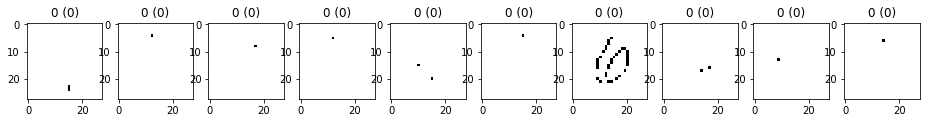

In [23]:
plot_labels(X_mnist, y_mnist, mnist_labels)

In [25]:
np.unique(y_mnist, return_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([13,  4,  1, 20,  5,  3, 10,  0, 18,  6]))

# Simple Feedforward Neural Net

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist,
                                                    stratify=y,
                                                    random_state=0)
# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

In [ ]:
model = train_model("dnn", dnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_dnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("dnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

In [ ]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "DNN - Learning Performance")

In [ ]:
# Run 3-fold cross-validation on specific architecture
eval_dnn(batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_dnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 6),
                   'h_l_1': (30, 500),
                   'h_l_2': (30, 500),
                   'h_l_3': (30, 500),
                   'h_l_4': (30, 500),
                   'h_l_5': (30, 500),
                   'h_l_6': (30, 500)}

opt_log = BO_NN(2, eval_dnn, "dnn", hyper_space_dnn,
                num_epochs=5, k_fold=3, logging=True, verbose=True)

# Simple Convolutional Neural Network

In [ ]:
# ConvNet Parameters
batch_size = 100
ch_sizes = [1, 16, 32]
k_sizes = [5, 5]
stride = 1
padding = 2
out_size = 10
num_epochs = 2
learning_rate = 0.001

# Instantiate the model with layersizes, Loss fct, optimizer
cnn_model = CNN(ch_sizes, k_sizes,
                stride, padding, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
model = train_model("cnn", cnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_cnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("cnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

In [ ]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "CNN - Learning Performance")

In [ ]:
# Run 3-fold cross-validation on specific architecture
eval_cnn(batch_size, learning_rate, num_layers=2,
         ch_1=16, ch_2=32, k_1=5, k_2=5,
         stride=1, padding=2,
         k_fold=2, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_cnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 5),
                   'ch_1': (3, 64),
                   'ch_2': (3, 64),
                   'ch_3': (3, 64),
                   'ch_4': (3, 64),
                   'ch_5': (3, 64),
                   'k_1': (2, 10),
                   'k_2': (2, 10),
                   'k_3': (2, 10),
                   'k_4': (2, 10),
                   'k_5': (2, 10),
                   'stride': (1, 3),
                   'padding': (1, 3)}

opt_log = BO_NN(3, eval_cnn, "cnn", hyper_space_cnn, logging=False, verbose=True)